In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def get_ids():
    return [name.split('.')[0] for name in os.listdir('C:\\Users\\Gabriel\\Documents\\images\\train\\')]

In [4]:
IDS = get_ids()

In [5]:
len(IDS)

13386

In [6]:
IMAGE_SIZE = 512
IMAGE_HEIGHT = IMAGE_SIZE
IMAGE_WIDTH = IMAGE_SIZE
GRID_SIZE = 64
GRID_DIM_X = IMAGE_SIZE//GRID_SIZE
GRID_DIM_Y = IMAGE_SIZE//GRID_SIZE

IMAGES_PATH = 'C:\\Users\\Gabriel\\Documents\\images\\train\\'
IMAGES_LABELS = 'C:\\Users\\Gabriel\\Documents\\labels\\train\\'

In [7]:
def get_image(image_id):
    image = plt.imread(IMAGES_PATH + image_id + '.jpg')
    image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    return image/255.0

In [8]:
def read_relative_points(image_id):
    path = IMAGES_LABELS + image_id + '.txt' 
    with open(path, mode='r') as f:
        relative_points = []
        for coord in f.readlines():
            relative_points.append(coord[:-1].split(' ')[1:])
    return relative_points

In [9]:
def visualize_labels_on_images(image_id, line=1):
    image = plt.imread(IMAGES_PATH + str(image_id) + '.jpg')
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    points = read_relative_points(image_id)
    for p in points:
        cx = float(p[0])*IMAGE_SIZE
        cy = float(p[1])*IMAGE_SIZE
        w = float(p[2])*IMAGE_SIZE
        h = float(p[3])*IMAGE_SIZE
    
        top_left_x = cx - w/2
        top_left_y = cy - h/2
        bottom_right_x = cx + w/2
        bottom_right_y = cy + h/2
        bottom_right_x, bottom_right_y, top_left_x, top_left_y
        init = int(top_left_x), int(top_left_y)
        end = int(bottom_right_x), int(bottom_right_y)
            
        image = np.array(image)
        image = cv2.rectangle(image, init, end, (0, 255, 0), line)
    plt.imshow(image)

In [10]:
def create_grids(id):
    points = read_relative_points(id)
    grid_tensor = np.zeros([IMAGE_WIDTH // GRID_SIZE, IMAGE_HEIGHT // GRID_SIZE, 5])

    for point in points:
        cx, cy = float(point[0]) * IMAGE_WIDTH, float(point[1]) * IMAGE_HEIGHT
        h, w = float(point[2]) * IMAGE_HEIGHT, float(point[3]) * IMAGE_WIDTH

        # Calcula o índice da célula da grid em que o centro do objeto está localizado
        grid_x = int(cx // GRID_SIZE)
        grid_y = int(cy // GRID_SIZE)

        # Verifica se o centro do objeto está dentro dos limites da imagem
        if 0 <= grid_x < IMAGE_WIDTH // GRID_SIZE and 0 <= grid_y < IMAGE_HEIGHT // GRID_SIZE:
            # Marca a presença do objeto e armazena as coordenadas normalizadas
            grid_tensor[grid_x, grid_y, 0] = 1  # Indica que há um objeto nessa célula
            grid_tensor[grid_x, grid_y, 1] = cx / IMAGE_WIDTH
            grid_tensor[grid_x, grid_y, 2] = cy / IMAGE_HEIGHT
            grid_tensor[grid_x, grid_y, 3] = h / IMAGE_HEIGHT
            grid_tensor[grid_x, grid_y, 4] = w / IMAGE_WIDTH

    return grid_tensor

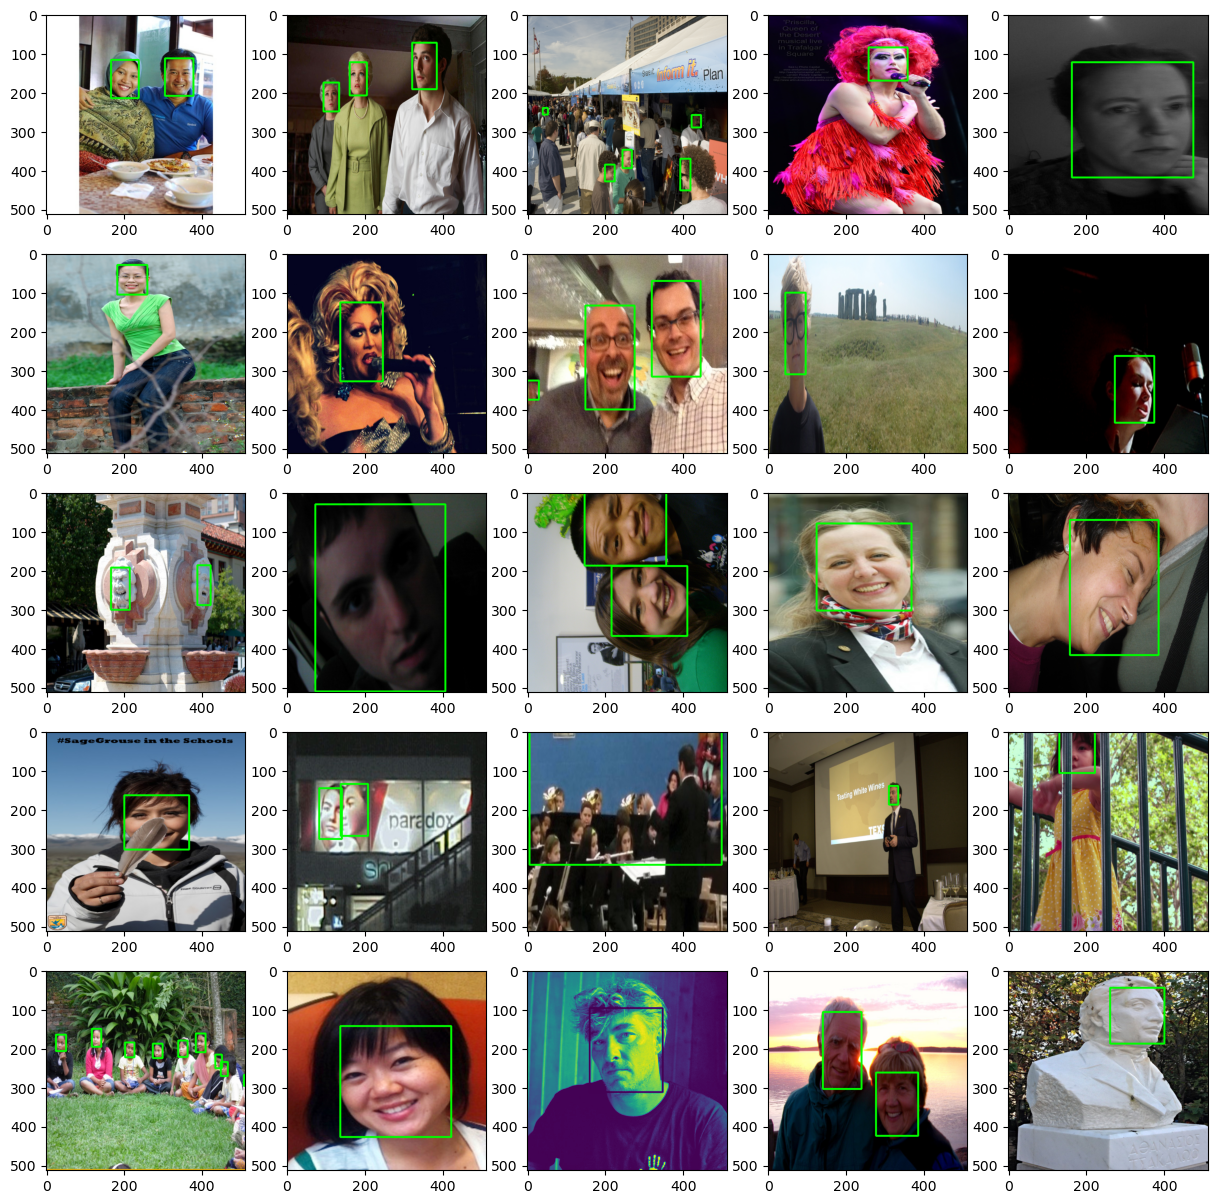

In [11]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    visualize_labels_on_images(IDS[i], 3)

In [11]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size, shuffle=True, **kwargs):
        super(DataGenerator, self).__init__(**kwargs)
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.batch_size = batch_size #3d-images per batch
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = get_image(ID)
            if img.shape[-1] >= 3 and len(img.shape) == 3:
                X.append(get_image(ID)[:,:,0:3])
                y.append(create_grids(ID))
        return X, y


In [12]:
def yolo_loss(y_true, y_pred, lambda_coord=5, lambda_noobj=0.5, epsilon=1e-7):
    # Separação das predições e verdadeiros
    pred_confidence = y_pred[..., 0]
    pred_xy = y_pred[..., 1:3]
    pred_wh = y_pred[..., 3:5]

    true_confidence = y_true[..., 0]
    true_xy = y_true[..., 1:3]
    true_wh = y_true[..., 3:5]

    # Add epsilon to avoid sqrt of zero
    coord_loss = tf.reduce_sum(
        tf.expand_dims(true_confidence, axis=-1) * (
            tf.square(true_xy - pred_xy) +
            tf.square(tf.sqrt(true_wh + epsilon) - tf.sqrt(pred_wh + epsilon))
        )
    )

    # Perda de Confiança
    obj_loss = tf.reduce_sum(true_confidence * tf.square(true_confidence - pred_confidence))
    noobj_loss = lambda_noobj * tf.reduce_sum((1 - true_confidence) * tf.square(pred_confidence))

    confidence_loss = obj_loss + noobj_loss

    # Perda total
    total_loss = coord_loss*0.3333 + confidence_loss*0.6666

    return total_loss

In [13]:
train_gen = DataGenerator(IDS[0:10000], 4)
val_gen = DataGenerator(IDS[10000:11500], 4)
test_gen = DataGenerator(IDS[11500:], 4)
tests = IDS[11500:]

In [14]:
def scheduler(epoch, lr):
    return lr*0.9

In [15]:
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [16]:
callback_loss = tf.keras.callbacks.ModelCheckpoint(
                    '/kaggle/working/yolo_weights.keras',
                    monitor='val_loss',
                    verbose=0,
                    save_best_only=True,
                    save_weights_only=False,
                    mode='auto',
                    save_freq='epoch',
                    initial_value_threshold=None)

In [17]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        
        self.main_conv = [tf.keras.layers.Conv2D(filters, kernel_size=1, padding='same'),
                          tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(0.2),
                          tf.keras.layers.Conv2D(filters, kernel_size=1, padding='same'),
                          tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(0.2)]
        
    def call(self, x):
        data = tf.identity(x)

        for layer in self.main_conv:
            data = layer(data)

        return data + x

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.filters,
                     })
        return config

In [18]:
yolo = tf.keras.Sequential()
yolo.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(7,7), padding='same')) 
yolo.add(tf.keras.layers.BatchNormalization())
yolo.add(tf.keras.layers.LeakyReLU(0.2))

yolo.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=2))
yolo.add(tf.keras.layers.BatchNormalization())
yolo.add(tf.keras.layers.LeakyReLU(0.2))

for _ in range(2):
    yolo.add(ResidualBlock(64))

yolo.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=2)) 
yolo.add(tf.keras.layers.BatchNormalization())
yolo.add(tf.keras.layers.LeakyReLU(0.2))

for _ in range(4):
    yolo.add(ResidualBlock(128))
    
yolo.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=2)) 
yolo.add(tf.keras.layers.BatchNormalization())
yolo.add(tf.keras.layers.LeakyReLU(0.2))

for _ in range(8):
    yolo.add(ResidualBlock(256))

yolo.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=2)) 
yolo.add(tf.keras.layers.BatchNormalization())
yolo.add(tf.keras.layers.LeakyReLU(0.2))

for _ in range(8):
    yolo.add(ResidualBlock(256))
    
yolo.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=2)) 
yolo.add(tf.keras.layers.BatchNormalization())
yolo.add(tf.keras.layers.LeakyReLU(0.2))

for _ in range(8):
    yolo.add(ResidualBlock(512))

yolo.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding='same', strides=2)) 
yolo.add(tf.keras.layers.BatchNormalization())
yolo.add(tf.keras.layers.LeakyReLU(0.2))

for _ in range(4):
    yolo.add(ResidualBlock(1024))
    
yolo.add(tf.keras.layers.Conv2D(5, kernel_size=1, padding='same', activation='sigmoid'))

yolo.build([None,IMAGE_WIDTH, IMAGE_HEIGHT, 3])
yolo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=yolo_loss)
yolo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512, 512, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 64)     256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 64)      0

In [21]:
h = yolo.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[callback_lr, callback_loss])

Epoch 1/20
2500/2500 [==============================] - 1875s 740ms/step - loss: 6.7812 - val_loss: 6.9132 - lr: 9.0000e-05
Epoch 2/20
2500/2500 [==============================] - 1880s 752ms/step - loss: 6.4126 - val_loss: 6.3125 - lr: 8.1000e-05
Epoch 3/20
2500/2500 [==============================] - 1856s 742ms/step - loss: 6.3927 - val_loss: 6.2133 - lr: 7.2900e-05
Epoch 4/20
2500/2500 [==============================] - 1711s 684ms/step - loss: 6.3400 - val_loss: 6.0926 - lr: 6.5610e-05
Epoch 5/20
2500/2500 [==============================] - 1658s 663ms/step - loss: 6.3341 - val_loss: 6.1288 - lr: 5.9049e-05
Epoch 6/20
2500/2500 [==============================] - 1663s 665ms/step - loss: 6.2804 - val_loss: 5.9907 - lr: 5.3144e-05
Epoch 7/20
2500/2500 [==============================] - 1664s 665ms/step - loss: 5.9576 - val_loss: 5.5967 - lr: 4.7830e-05
Epoch 8/20
2500/2500 [==============================] - 1664s 665ms/step - loss: 5.3546 - val_loss: 5.0385 - lr: 4.3047e-05
Epoch 9/

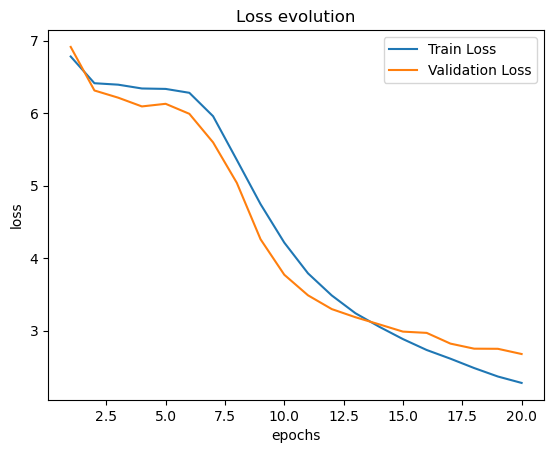

In [22]:
plt.plot(list(range(1, 21)), h.history['loss'])
plt.plot(list(range(1, 21)), h.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss evolution')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [19]:
yolo.load_weights('/kaggle/working/yolo_weights.keras')

In [34]:
yolo.evaluate(val_gen)

375/375 [==============================] - 83s 221ms/step - loss: 2.6970


2.697004795074463

In [33]:
yolo.evaluate(test_gen)

471/471 [==============================] - 104s 219ms/step - loss: 2.7179


2.717909812927246

In [20]:
def test_yolo_results(image, threshold=0.66):
    input_image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    # Get model predictions
    y_pred = yolo.predict(input_image)  # Output shape: (1, GRID_DIM_X, GRID_DIM_Y, 5)
    y_pred = y_pred[0]  # Remove batch dimension, shape: (GRID_DIM_X, GRID_DIM_Y, 5)
    
    boxes = []
    GRID_DIM_X = IMAGE_WIDTH // GRID_SIZE
    GRID_DIM_Y = IMAGE_HEIGHT // GRID_SIZE
    
    # Process predictions to extract bounding boxes
    for grid_x in range(GRID_DIM_X):
        for grid_y in range(GRID_DIM_Y):
            cell = y_pred[grid_x, grid_y]
            confidence = cell[0]
            if confidence > threshold:
                # Denormalize coordinates
                cx = cell[1] * IMAGE_WIDTH
                cy = cell[2] * IMAGE_HEIGHT
                w = cell[3] * IMAGE_HEIGHT
                h = cell[4] * IMAGE_WIDTH
                 
                
                # Calculate bounding box corners
                x1 = int(cx - w / 2)
                y1 = int(cy - h / 2)
                x2 = int(cx + w / 2)
                y2 = int(cy + h / 2)
                
                boxes.append([x1, y1, x2, y2])
    
    # Prepare image for drawing
    image_display = (image * 255).astype(np.uint8)
    
    # Draw predicted bounding boxes in green
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image_display, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_display)
    plt.axis('off')
    plt.show()

In [26]:
pathfile = 'C:\\Users\\Gabriel\\Desktop\\images\\'
images = os.listdir(pathfile)

1/1 [==============================] - 0s 41ms/step


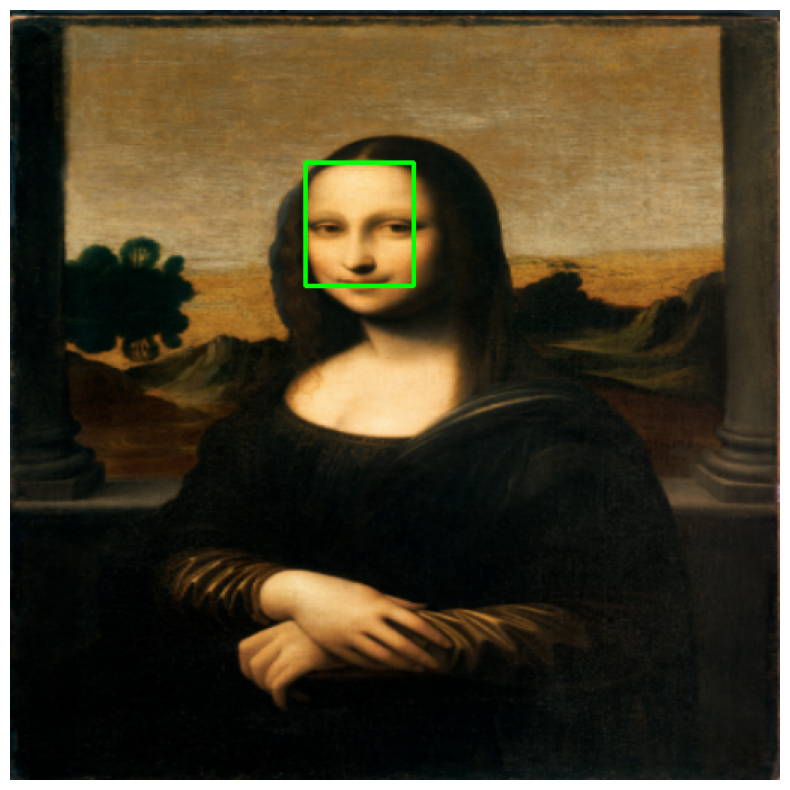

In [72]:
image = plt.imread(pathfile + image_names[0])
image = cv2.resize(image[:,:,:3], (512, 512))
test_yolo_results(image, 0.5)
    

In [57]:
guilherme_paths = 'C:\\Users\\Gabriel\\Desktop\\guilherme\\'

1/1 [==============================] - 0s 47ms/step


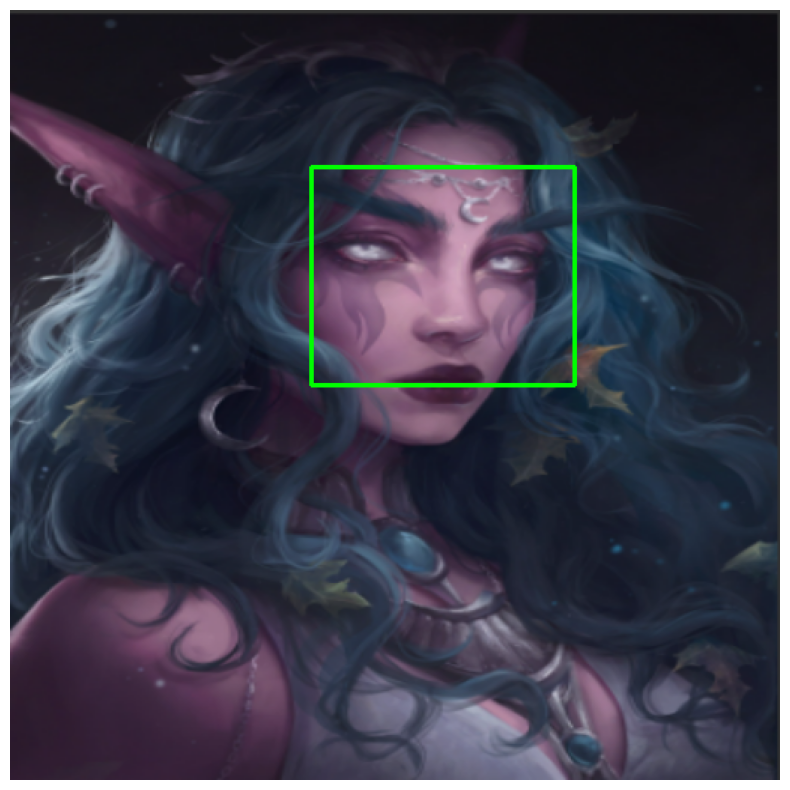

In [74]:
image = plt.imread(pathfile + image_names[0])
image = cv2.resize(image[:,:,:3], (512, 512))
test_yolo_results(image, 0.5)
    

1/1 [==============================] - 0s 37ms/step


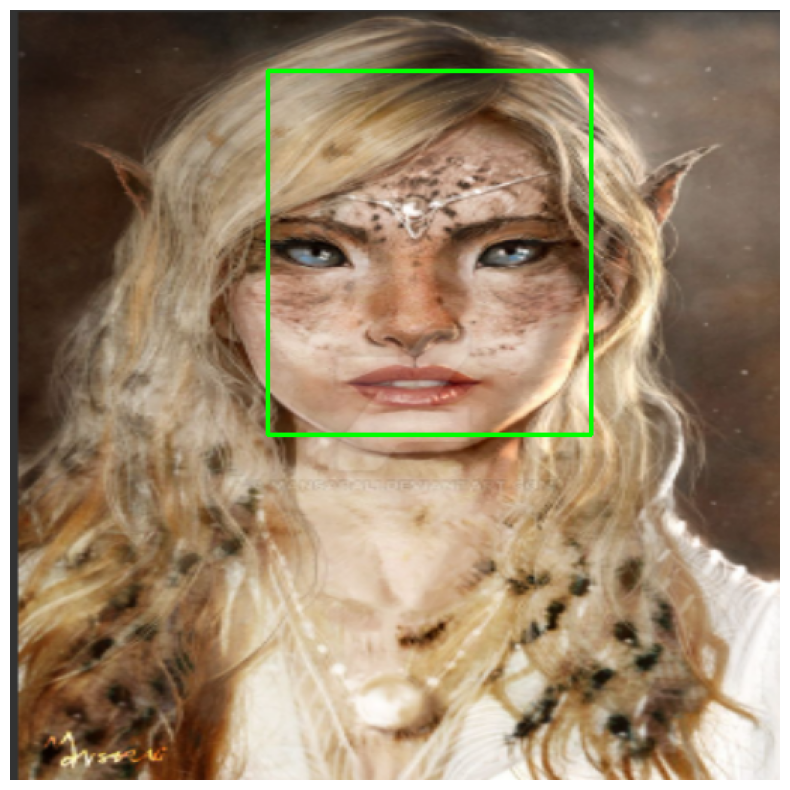

In [75]:
image = plt.imread(pathfile + image_names[1])
image = cv2.resize(image[:,:,:3], (512, 512))
test_yolo_results(image, 0.5)
    

1/1 [==============================] - 0s 40ms/step


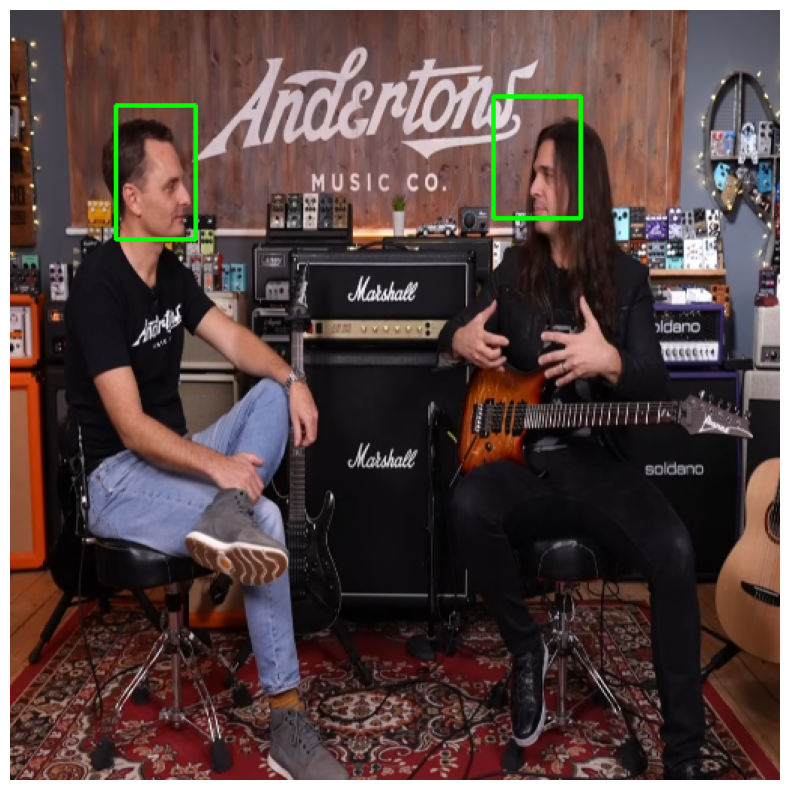

In [36]:
image = plt.imread(pathfile + images[2])
image = cv2.resize(image[:,:,:3], (512, 512))
test_yolo_results(image, 0.5)
    

1/1 [==============================] - 0s 45ms/step


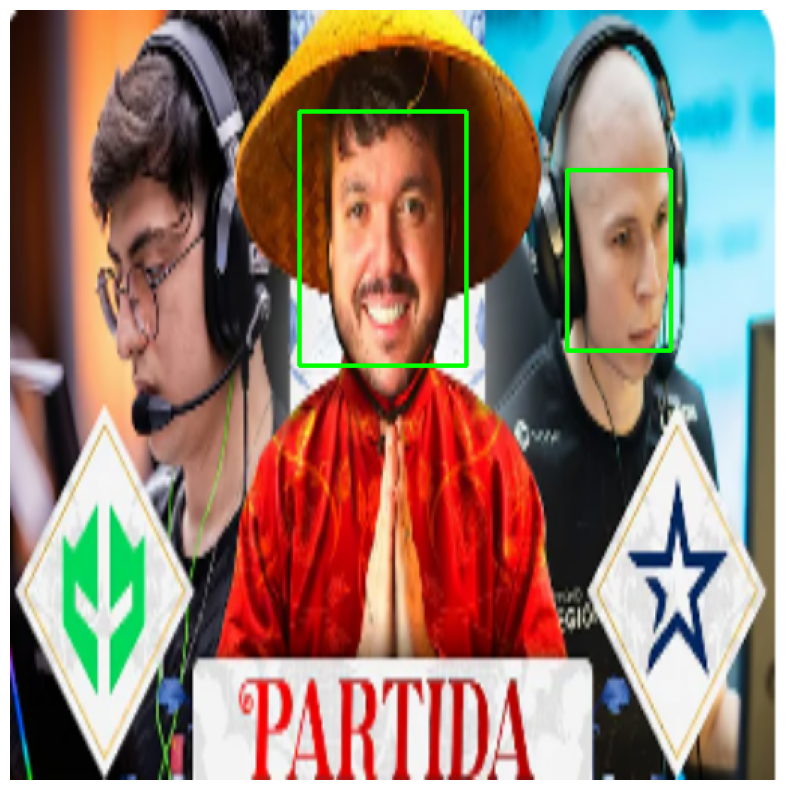

In [42]:
image = plt.imread(pathfile + image_names[3])
image = cv2.resize(image[:,:,:3], (512, 512))
test_yolo_results(image, 0.5)
    

1/1 [==============================] - 0s 39ms/step


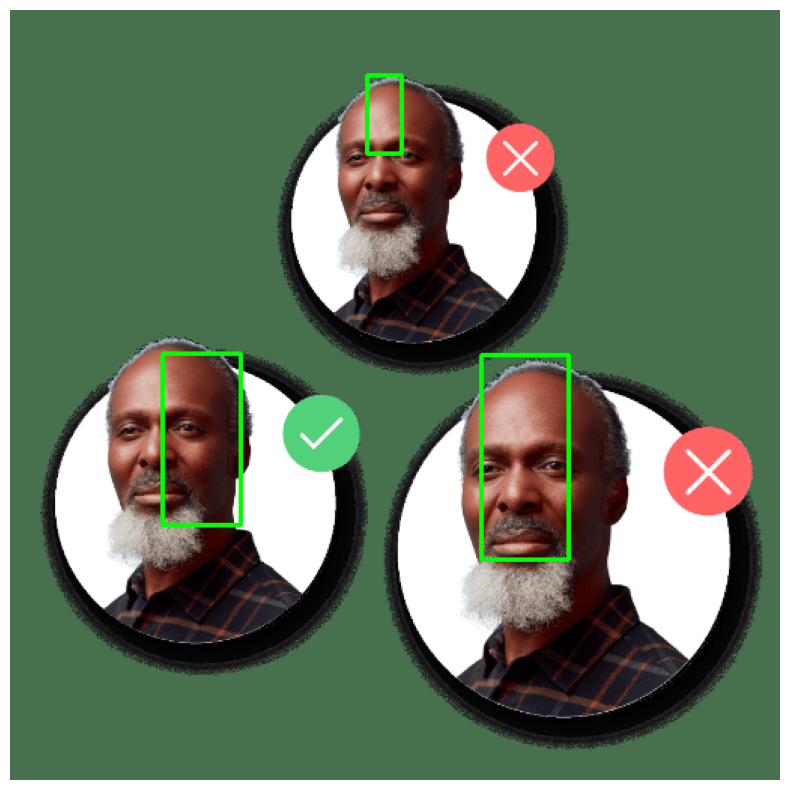

In [43]:
image = plt.imread(pathfile + image_names[4])
image = cv2.resize(image[:,:,:3], (512, 512))
test_yolo_results(image, 0.5)
    